### Let's go with Manual Merge. The methods are not working

In [1]:
NOLA_WALKING_PICKLE = "data/nola_walking_network.graphml"
NOLA_TRANSIT_PICKLE = "data/nola_transit_network.pickle"

In [42]:
from final_project.__main__ import load_osmnx_graph, load_peartree_graph, make_nodes_df_from_pg
from final_project.network import Network
from final_project.utilities import nearest_k_nodes, get_shortest_pair, get_route_length
from final_project.merge import convert_length_to_meter

import pandas as pd
import numpy as np
import networkx as nx
import folium
import osmnx as ox

In [3]:
OG = load_osmnx_graph(filepath=NOLA_WALKING_PICKLE)
PG = load_peartree_graph(filepath=NOLA_TRANSIT_PICKLE)

### Step 1: Make Two Networks

In [4]:
OG

In [5]:
PG

### Standardize

In [6]:
OG = convert_length_to_meter(OG)

### Step 2: Get the nodes in PG. And then get their distances to the points in OG

In [7]:
pg_nodes = make_nodes_df_from_pg(PG)

/Users/filip/code/anaconda3/envs/trox/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [8]:
xarr = pg_nodes["x"].to_numpy()

In [9]:
yarr = pg_nodes["y"].to_numpy()

In [10]:
nodes, dist = nearest_k_nodes(OG, X=xarr, Y=yarr, k=1, return_dist=True)
nodes_flat = np.array(nodes).reshape(len(nodes))
dist_flat = np.array(dist).reshape(len(dist))

/Users/filip/code/harvard/adv_python/final_project/2021sp-final-project-filipwodnicki/final_project/utilities.py:91: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  nn = nodes.index[pos]


In [11]:
pg_nodes = pg_nodes.reset_index().join(pd.Series(nodes_flat, name="nearest_node")).join(pd.Series(dist_flat, name="dist"))

In [12]:
def convert_meters_to_seconds(m, kph=4.5):
    kilometers = m / 1000
    hours = kilometers / kph
    return hours * 60 * 60

In [13]:
pg_nodes["time"] = pg_nodes["dist"].apply(convert_meters_to_seconds)

In [14]:
G = nx.union(OG, PG)

In [15]:
G.nodes.get("0DKDI_1645")

{'boarding_cost': 356.0439560439561,
 'modes': ['0'],
 'y': 29.957434,
 'x': -90.075405}

In [16]:
G["0DKDI_1645"]

AdjacencyView({'0DKDI_1935': {0: {'length': 56.833333333333336, 'mode': 'transit'}}})

In [17]:
pg_tuples = [(row[0], row[6], dict(length=row[8], mode="walk")) for _, row in pg_nodes.iterrows()]

In [ ]:
G.add_edges_from(pg_tuples)

In [19]:
pg_tuples_reverse = [(row[6], row[0], dict(length=row[8], mode="walk")) for _, row in pg_nodes.iterrows()]

In [ ]:
G.add_edges_from(pg_tuples_reverse)

### Visualize subgraph

In [51]:
pt1 = (29.922279216104823, -90.11460261754031)

In [22]:
[nodes] = nearest_k_nodes(G=G, X=pt1[1], Y=pt1[0], k=500)

/Users/filip/code/anaconda3/envs/trox/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/filip/code/harvard/adv_python/final_project/2021sp-final-project-filipwodnicki/final_project/utilities.py:91: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  nn = nodes.index[pos]


In [23]:
sub = G.subgraph(nodes)

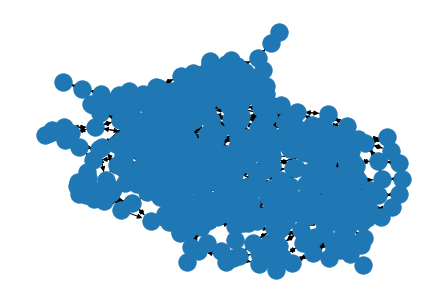

In [24]:
nx.draw(sub)

### Plotting code

In [25]:
m = folium.Map(zoom_start=18)

### Perform routing

In [28]:
pt2 = (29.922279463899343, -90.10549975576711)

In [46]:
route = get_shortest_pair(G, pt1, pt2)[0]

/Users/filip/code/anaconda3/envs/trox/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/filip/code/harvard/adv_python/final_project/2021sp-final-project-filipwodnicki/final_project/utilities.py:91: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  nn = nodes.index[pos]
/Users/filip/code/anaconda3/envs/trox/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https

In [48]:
get_route_length(G, route)

462.27252961262553

In [50]:
ox.plot_route_folium(G, route, route_map=m, color="magenta")